[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial_5.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial_5.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 5: Internal Climate Variability**

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorial Objectives**
In this tutorial, we will learn about the concept of internal climate variability, how it influences the predictability of climate phenomena and how it contributes to uncertainty in CMIP6 models. We will work with a *single-model ensemble*, which utilizes the *MPI-ESM1-2-LR* model from CMIP6, to isolate and quantify internal climate variability. 

By the end of this tutorial, you would be able to:
- Understand the importance of internal climate variability and its role in climate prediction and model uncertainty.
- Create and evaluate a single-model ensemble using IPCC uncertainty bands, providing a visual representation of model uncertainty.
- Contrast the uncertainty due to internal variability against the uncertainty within a multi-model ensemble (which includes internal variability *and* the impacts of human/coding choices).

# **Setup**

    



In [1]:
# !pip install condacolab &> /dev/null        
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

In [2]:
# imports
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

%matplotlib inline

In [4]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]['historical'].ds.sel(time=slice('1950', '1980')).mean() 
        dt_out[model] = subtree - ref
    return dt_out


def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim='time')

In [5]:
# @title Video 5: Internal Climate Variability 
#Tech team will add code to format and display the video

# **Section 1: Internal Climate Variability & Single-model Ensembles**

One of the CMIP6 models we are using in today's tutorials, *MPI-ESM1-2-LR* is part of single-model ensemble, where its modelling center carried out multiple simulations of the model for many of the CMIP6 experiments.

Let's take advantage of this single-model ensemble to quantify the internal variability of this model's simulated climate, and contrast this against the multi-model uncertainty we diagnosed in the previous tutorial.

### **Coding Exercise 1.1**

Complete the following code to:


1.   Load 5 different *realizations* of the *MPI-ESM1-2-LR* experiments (*r1i1p1f1* through *r5i1p1f1*). This numbering convention means they were each initialized using a different time-snapshot of the base/spin-up simulation.
2.   Plot the *historical* and *SSP1-2.6* experiment data for each realization, using a distinct color for each realization, but keeping that color the same across both the historical period and future period for a given realization.


In [6]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

cat_ensemble = col.search(
    source_id='MPI-ESM1-2-LR',
    variable_id='tos',
    table_id='Omon',
    # select the 5 ensemble members described above
    member_id=..., 
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id', 'member_id']
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_ensemble.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_ensemble = cat_ensemble.to_datatree(**kwargs)

# add the area (we can reuse the area from before, since for a given model the horizontal are does not vary between members)
dt_ensemble_with_area = DataTree()
for model,subtree in dt_ensemble.items():
    metric = dt_area['MPI-ESM1-2-LR']['historical'].ds['areacello'].squeeze()
    dt_ensemble_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)
    
# global average
# average every dataset in the tree globally
dt_ensemble_gm = dt_ensemble_with_area.map_over_subtree(global_mean)

# calculate anomaly
dt_ensemble_gm_anomaly = datatree_anomaly(dt_ensemble_gm)

def plot_historical_ssp126_ensemble_combined(dt,ax):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.coarsen(time=12).mean().tos)

        # concatenate the historical and ssp126 timeseries for each ensemble member
        da_combined = ...
        # plot annual averages
        da_combined.plot(hue='member_id',ax=ax)

fig,ax=plt.subplots()
plot_historical_ssp126_ensemble_combined(dt_ensemble_gm_anomaly,ax)

ax.set_title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
ax.set_ylabel('Global Mean SST Anomaly [$^\circ$C]')
ax.set_xlabel('Year')


TypeError: 'ellipsis' object is not iterable


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


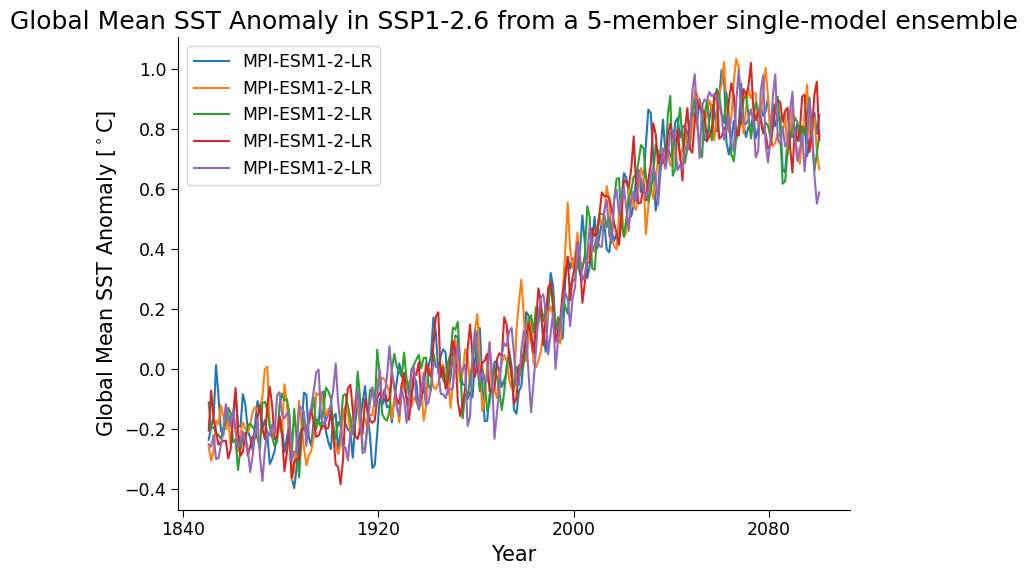

In [12]:
# to_remove solution
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

cat_ensemble = col.search(
    source_id='MPI-ESM1-2-LR',
    variable_id='tos',
    table_id='Omon',
    # select the 5 ensemble members described above
    member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1'],
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id', 'member_id']
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_ensemble.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_ensemble = cat_ensemble.to_datatree(**kwargs)

cat_area = col.search(
    source_id=['MPI-ESM1-2-LR'],
    variable_id='areacello', # for the coding exercise, ellipses will go after the equals on this line
    member_id='r1i1p1f1',
    table_id='Ofx', # for the coding exercise, ellipses will go after the equals on this line
    grid_label='gn',
    experiment_id = ['historical'], # for the coding exercise, ellipses will go after the equals on this line
    require_all_on = ['source_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

# add the area (we can reuse the area from before, since for a given model the horizontal are does not vary between members)
dt_ensemble_with_area = DataTree()
for model,subtree in dt_ensemble.items():
    metric = dt_area['MPI-ESM1-2-LR']['historical'].ds['areacello'].squeeze()
    dt_ensemble_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)
    
# global average
# average every dataset in the tree globally
dt_ensemble_gm = dt_ensemble_with_area.map_over_subtree(global_mean)

# calculate anomaly
dt_ensemble_gm_anomaly = datatree_anomaly(dt_ensemble_gm)
    
def plot_historical_ssp126_ensemble_combined(dt,ax):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.coarsen(time=12).mean().tos)

        # concatenate the historical and ssp126 timeseries for each ensemble member
        da_combined = xr.concat(datasets, dim='time')
        # plot annual averages
        da_combined.plot(hue='member_id',ax=ax)

fig,ax=plt.subplots()
plot_historical_ssp126_ensemble_combined(dt_ensemble_gm_anomaly,ax)

ax.set_title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
ax.set_ylabel('Global Mean SST Anomaly [$^\circ$C]')
ax.set_xlabel('Year')


### **Coding Exercise 1.2**

Complete the following code to:


1.   Repeat the final figure of the last tutorial, except now display means and uncertainty bands of the single-model ensemble that you just loaded, rather than the multi-model ensemble analyzed in the previous tutorial.

In [ ]:
fig,ax=subplots()
for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    da = dt_ensemble_gm_anomaly['MPI-ESM1-2-LR'][experiment].ds.tos.coarsen(time=12).mean().load()
    # calculate the mean across ensemble members
    da.mean(...).plot(color=color, label=experiment,ax=ax)

    # shading representing spread between members 
    x = da.time.data
    # diagnose the lower range of the likely bounds
    da_lower = ...
    # diagnose the upper range of the likely bounds
    da_upper = ...
    ax.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color) 

ax.set_title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
ax.set_ylabel('Global Mean SST Anomaly [$^\circ$C]')
ax.set_xlabel('Year')
ax.legend()

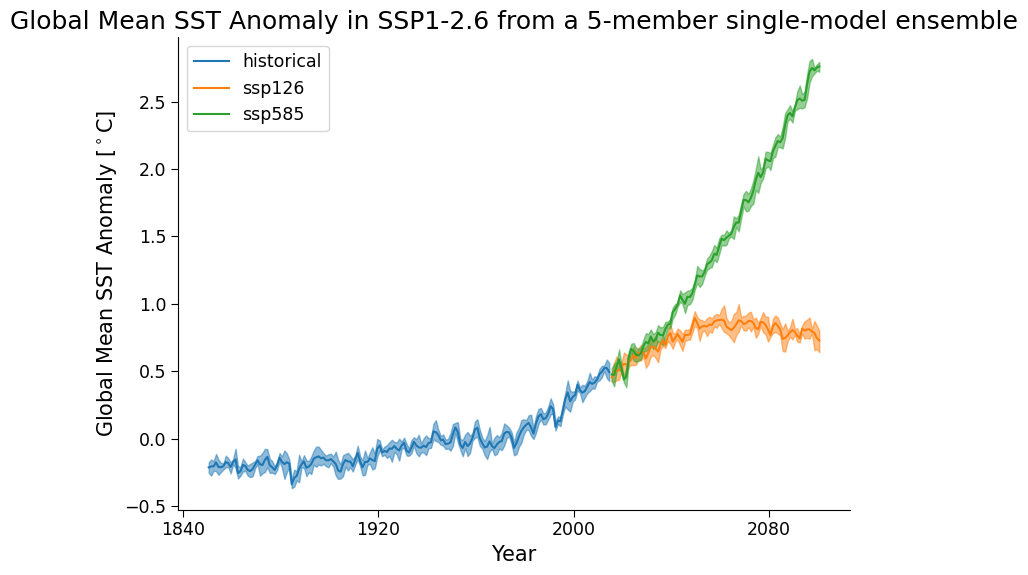

In [11]:
# to_remove solution
fig,ax=plt.subplots()
for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    da = dt_ensemble_gm_anomaly['MPI-ESM1-2-LR'][experiment].ds.tos.coarsen(time=12).mean().load()
    # calculate the mean across ensemble members
    da.mean('member_id').plot(color=color, label=experiment,ax=ax)

    # shading representing spread between members 
    x = da.time.data
    # diagnose the lower range of the likely bounds
    da_lower = da.squeeze().quantile(0.17, dim='member_id')
    # diagnose the upper range of the likely bounds
    da_upper = da.squeeze().quantile(0.83, dim='member_id')
    ax.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color) 

ax.set_title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
ax.set_ylabel('Global Mean SST Anomaly [$^\circ$C]')
ax.set_xlabel('Year')
ax.legend()

### **Question 1.2: Climate Connection**

1. How does this figure compare to the multi-model ensemble figure from the previous tutorial (included below)? Can you interpret differences using the science we have discussed today?

![tutorial 4 solution](./img/W2D1_Tutorial_5_Insert_Figure.png)

In [ ]:
# to_remove explanation

"""
1. The uncertainty of the single-model ensemble is much smaller than the uncertainty of the multi-model ensemble. The single-model ensemble variations are driven only by internal climate variability, whereas the multi-model ensemble includes inter-model differences (numerics, physics, discretization) in addition to internal climate variability. Comparing the two plots suggests that most of our uncertainty in future projections of global mean SST come from inter-model differences. Internal climate variability is a relatively small contributor to this uncertainty.
""";

# **Summary**
In this tutorial, we explored the internal climate variability and its implications for climate modeling and prediction. We discussed the utility of single-model ensembles for isolating the effects of internal variability by contrasting simulations with identical physics, numerics, and discretization. We quantified the internal variability of *MPI-ESM1-2-LR* model's simulated climate and compared it to the uncertainty introduced by multi-model ensembles. Through this tutorial, we better understand the boundaries of climate prediction and the different sources of uncertainty in CMIP6 models.

# **Resources**

Data for this tutorial can be accessed [here](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html).